# EOF Analysis
In this example we will use SST data from the NCEP Reanalysis to compute EOFs and PCs for the tropical Pacific. Any sort of analysis will be the topic of a separate lab.

## Prepare the data
We'll start by loading the data. The netCDF file can be downloaded by pasting the following into a web browser, or by using an ftp client.

ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface_gauss/skt.sfc.mon.mean.nc

This file is actually a skin temperature file. To get SST only, we need the acompanying land/sea mask.

ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface_gauss/lsmask.19294.nc

Then, import the necessary modules

In [1]:
%matplotlib inline
from netCDF4 import Dataset, num2date
from matplotlib import cm, rcParams, pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

### Unpacking the netCDF file
The Dataset function opens the netCDF file, and we can examine a few things about it. Let's see what variables are in it, and what their dimensions are. The 'variables' attribute of a netCDF4 Dataset is an ordered dictionary containing netCDF variable objects.

In [2]:
data = Dataset('skt.sfc.mon.mean.nc')
variables = data.variables
print type(variables)

for var in variables:
    print('%s has %i dimension(s), consisting of %s' % 
          (var, variables[var].ndim, variables[var].dimensions))

<class 'collections.OrderedDict'>
lat has 1 dimension(s), consisting of (u'lat',)
lon has 1 dimension(s), consisting of (u'lon',)
time has 1 dimension(s), consisting of (u'time',)
skt has 3 dimension(s), consisting of (u'time', u'lat', u'lon')


Okay, so there are 4 variables - latitude, longitude, time, and skin temperature. The first three are all one dimensional, and the skin temperature is 3 dimensional, indexed by the first three variables. This makes sense.

Now we can use a nifty list comprehension to extract the netCDF variables. If you want to understand whats happening, google list comprehensions, or write an explicit for loop and insert print statements as needed. 


In [3]:
lat, lon, time, skt = [variables[var] for var in variables]

Note that these variables are netCDF4 variable objects. This means they each have a bunch of information (attributes) about the data contained in the variable, not just the data itself. All the info can be seen by printing the variable.

In [4]:
print lat

<type 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    actual_range: [ 88.54199982 -88.54199982]
    long_name: Latitude
    standard_name: latitude
    axis: Y
unlimited dimensions: 
current shape = (94,)
filling on, default _FillValue of 9.96920996839e+36 used



Individual attributes can be accessed easily - for instance, if we wanted to see the units of each of our variables, we could run the following:

In [5]:
for var in [lat, lon, time, skt]:
    print '%s measured in %s' % (var.name, var.units)

lat measured in degrees_north
lon measured in degrees_east
time measured in hours since 1800-01-01 00:00:0.0
skt measured in degC


This all looks great, except for the time variable.. Let's check it out. Variable data is accessed by the 'slice' operator, [:]. Lets look at the first 5 values of the time variable.

In [6]:
time[:5]

array([ 1297320.,  1298064.,  1298760.,  1299504.,  1300224.])

Oy. It really is measured in hours since midnight of January 1st, 1800.

The dataset is for monthly skin temperature values. We would prefer that the timestep is something more reasonable like year/month values. 

Hello, num2date. This function can convert numbers into datetime objects as long as we tell num2date what the units are. Fortunately, this is really easy because the time variable has a units attribute. 

num2date returns a numpy array of datetime objects - lets look at the first and last ones.

In [7]:
dates = num2date(times = time[:], units = time.units, calendar = 'standard')
print dates[0]
print dates[-1]

1948-01-01 00:00:00
2016-02-01 00:00:00


Great. If you check the download page, you'll see that the NCEP reanalysis we are using starts January of 1948, and it currently has been updated through February 2016.

We're going to finish by converting this array of datetime objects to a pandas DatetimeIndex, which I peronally prefer for working with continuous time series. Check out all the attributes - you can access years, months, days, etc..

In [8]:
dates = pd.DatetimeIndex(dates)
print dates[:3]

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01'], dtype='datetime64[ns]', freq=None)


### Extract data
Now that we have our time situation sorted, lets extract the data we want. We'll need to set up some indexing variables - lets put them in a dictionary called 'idx'. We're analyzing the tropical Pacific, so we'll want those latitude/longitude boundaries, and lets work with the years 1950-2010

In [9]:
idx = {}
idx['lat'] = (lat[:] >= -30) & (lat[:] <= 30)
idx['lon'] = (lon[:] >= 120) & (lon[:] <= 285)
idx['time'] = (dates.year >= 1950) & (dates.year <= 2010)

Now, use the indices to extract the data. We know the order of the skt dimensions from above - (time, latitude, longitude).

In [10]:
lons = lon[idx['lon']]
lats = lat[idx['lat']]
tims = dates[idx['time']]
ssts = skt[idx['time'], idx['lat'], idx['lon']]

Finally, we need to get the land/sea mask, and we only want the land mask variable so we'll just grab it right away.

In [11]:
lsmask = Dataset('lsmask.19294.nc')['lsmask']
lsmask = lsmask[:, idx['lat'], idx['lon']]
lsmask.shape

(1, 32, 89)

We can see it has a time dimension - this will be useful, because we can tile over it easily to match the dimensions of our data - we want to keep the lat/lon information the same, and repeat it for every time step, because the land/sea mask doesn't change depending on the month. You can always type help(function_name) to understand what the arguments mean.

In [12]:
lsmask = np.tile(lsmask, reps = [len(tims), 1, 1])
lsmask.shape

(732, 32, 89)

Great, now the lsmask is the same shape as our SST data, and we can use it to create a masked array. This really simpilfies dealing with the 'land' grids when doing the EOF analysis and then plotting the results on a map.

In [13]:
ssts = np.ma.masked_array(data = ssts, mask = lsmask == -1)

At this point, there are a few more (totally optional but beneficial depending on the application) things you can do before computing EOFs, namely removing the annual cycle (the mean of each month), detrending the data, and applying a 3 month rolling average to temporally smooth the data. As always, put print statements into the function if you want to understand what the loops are doing.

In [14]:
def remove_anncyc(data, nmon = 12):
    nt, ny, nx = data.shape
    #_reshape data into 2 dimenions - time and space
    data = data.reshape(nt, ny*nx)
    tmax, ngrid = data.shape
    
    #_initialize climatology array
    clim = np.zeros((nmon, ngrid))
    for month in np.arange(12):
        idx = np.arange(month, tmax, 12)
        clim[month, :] = data[idx].mean(axis = 0)
    clim = np.tile(clim, [nt/nmon, 1])
    data = (data - clim).reshape(nt, ny, nx)
    return data, clim

ssts, clim = remove_anncyc(ssts)

In [15]:
def detrend(data):
    from scipy.signal import detrend
    #_detrend removes the mean from the data as well
    #_but for these purposes we want to add it back in
    avg = data.mean(axis = 0)
    data = detrend(data, axis = 0) + avg
    return data

ssts = detrend(ssts)

In [16]:
def rolling_avg(data):
    nt, ny, nx = data.shape
    data = data.reshape(nt, ny*nx)
    temp = pd.rolling_mean(data, window = 3, center = True)
    
    #_the first and last time steps are NaNs because of our window
    #_so lets manually add them back in by averaging the months next to 
    #_them
    
    data[0] = (data[0] + data[1]) / 2
    data[-1] = (data[-1] + data[-2]) / 2
    
    #_fill the rest with the calculated rolling average.
    data[1:-1] = temp[1:-1]
    
    return data.reshape(nt, ny, nx)
ssts = rolling_avg(ssts)

### EOFs
Now we can do the EOF analysis! Let's start by computing a weight vector (gridded data needs to be weighted by the square root of the cosine of latitude).

In [17]:
wgts = np.sqrt(np.abs(np.cos(np.radians(lats))))[..., np.newaxis]

EOF analysis is made really easy by the eofs package (AND it supports masked arrays!)

In [18]:
from eofs.standard import Eof
solver = Eof(ssts, weights = wgts)

Let's get the first EOF and PC.

In [19]:
#_get the first eof from the solver, scale it by multiplying by the
#_square root of eigenvalue (see solver help)
#_you can get multiple eofs so, it is returned in 3 dimensions
#_only want one here so squeeze it
eof1 = solver.eofs(neofs = 1, eofscaling = 2).squeeze()
pc1 = solver.pcs(npcs = 1).squeeze()

Easy! Now plot them. sstMaps2 is a function that takes a 2D spatial grid of values with the latitudes and longitudes of the grid, with optional fig/ax arguments, and makes a map.

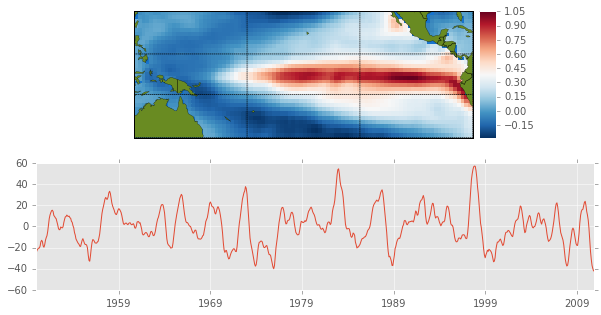

In [20]:
from smapFuncts import sstMap2
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10,5))
fig, ax1, m = sstMap2(eof1, lats, lons, fig = fig, ax = ax1)
ax2.plot(tims, pc1);

If we wanted, would be easy to look at several EOFs at once.

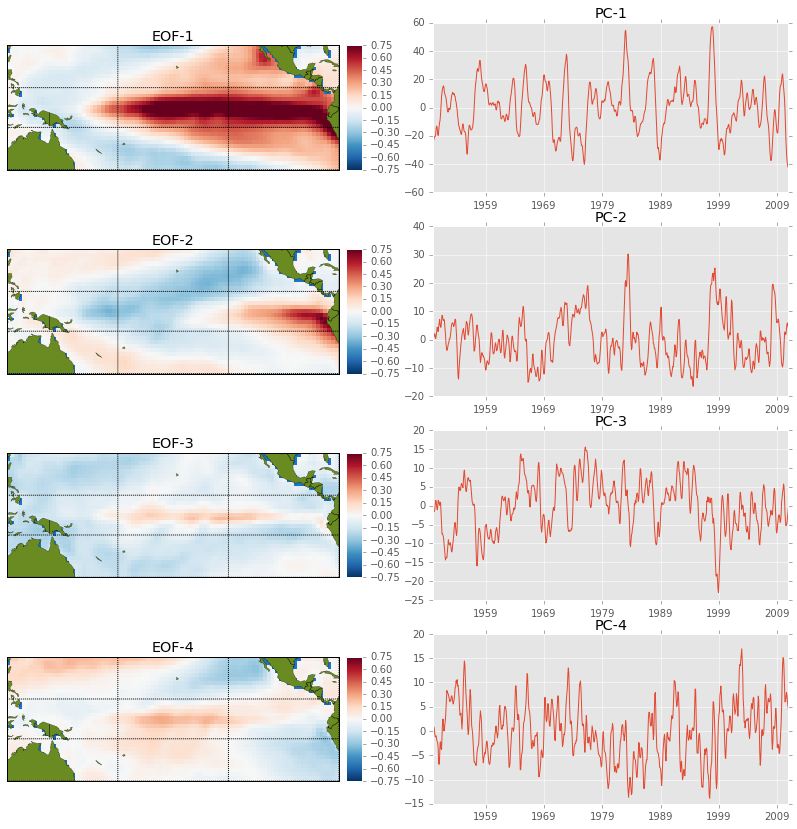

In [21]:
n = 4
eofs = solver.eofs(neofs = n, eofscaling = 2)
pcs = solver.pcs(npcs = n)

fig, axes = plt.subplots(4, 2, figsize = (14,14))
for i, (l_ax, r_ax) in zip(range(n), axes):
    fig, l_ax, m = sstMap2(eofs[i], lats, lons, fig = fig, ax = l_ax,
                            vmin = -0.75, vmax = 0.75)
    l_ax.set_title('EOF-%i' % (i + 1))

    r_ax.plot(tims, pcs[:,i])
    r_ax.set_title('PC-%i' % (i + 1))

The EOF solver has all kinds of fun methods and attributes, from projecting other data onto your EOF fields (i.e. predictions regarding EOFs) to reconstructing the data field from a certain number of leading EOF patterns. It even has Norths Rule of Thumb built into it to get the error bars for your scree plots of eigenvalues! Oh boy..